# Latent Dimensions I: Matrix Factorization

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# read in the data and transform it
df = pd.read_excel('../data/reviews.xlsx')
df = df[df.clean_text.isna()==False]
documents = df.clean_text.apply(str).tolist()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', analyzer='word', min_df=0.001, max_df=0.5, sublinear_tf=True, use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(434292, 2417)


## SVD

In [56]:
from sklearn.decomposition import TruncatedSVD

# set number of latent components
k = 10

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

CPU times: user 8.04 s, sys: 669 ms, total: 8.71 s
Wall time: 3.39 s


In [57]:
print(U.shape, S.shape, V.shape)

(434292, 10) (10,) (10, 2417)


## NMF

In [58]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 1min 12s, sys: 1.38 s, total: 1min 14s
Wall time: 19.5 s


In [59]:
print(W.shape, H.shape)

(434292, 10) (10, 2417)


## Latent topics

In [66]:
import numpy as np
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [70]:
S

array([105.13267663,  64.9919272 ,  60.58954997,  55.83079388,
        53.34989628,  52.21177281,  50.01896696,  47.35916265,
        45.92600418,  45.73782265])

In [68]:
terms = tfidf_vectorizer.get_feature_names()

sorted(show_topics(V, terms))

['easy, use, easy use, website, flower',
 'flower, good, good price, price, deliver',
 'great, delivery, tyre, fast, fast delivery',
 'great, service, great service, day, great price',
 'order, flower, deliver, day, arrive',
 'phone, day, send, money, mazuma',
 'quick, delivery, quick delivery, excellent, tyre',
 'service, flower, excellent, great, fast',
 'service, order, good, day, delivery',
 'tyre, service, fit, time, recommend']

In [69]:
sorted(show_topics(H, terms))

['easy, use, easy use, website, site',
 'flower, deliver, beautiful, flower deliver, time',
 'good, price, good price, good service, price good',
 'great, fast, delivery, fast delivery, product',
 'order, arrive, day, item, arrive day',
 'phone, send, money, day, mazuma',
 'quick, quick delivery, delivery, quick easy, service quick',
 'recommend, company, friend, highly, definitely',
 'service, excellent, excellent service, customer, customer service',
 'tyre, fit, time, tyre fit, fitter']

## Visualization

In [81]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('poster')


def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. If supplied, color them according to the labels
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('afmhot') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], df2['z'], c=label_colors[l], cmap=cMap, edgecolor=None, label=label, alpha=0.3, s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], c=label_colors[l], cmap=cMap, edgecolor=None, label=label, alpha=0.3, s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

In [87]:
# create 3-dimensional document embeddings
low_dim_svd = TruncatedSVD(n_components=2)
low_dim_nmf = NMF(n_components=2, init='nndsvd')

# let's visualize only the first 200 documents
Z = X[:200]
categories = df.category[:200]

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

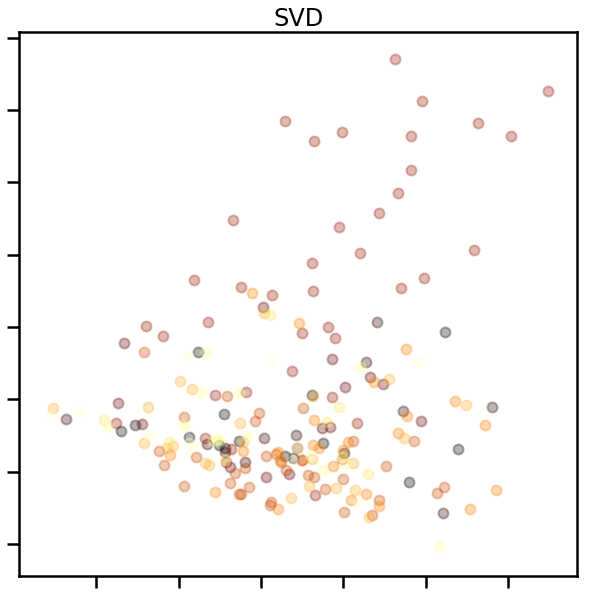

In [88]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

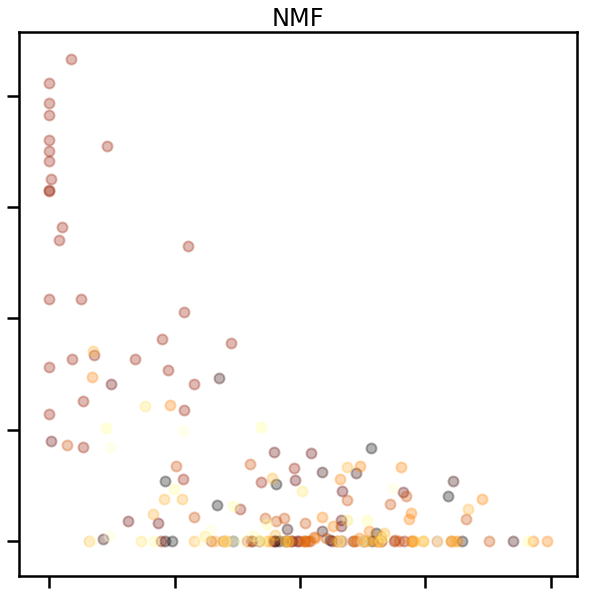

In [89]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=2)

# Latent Dimensions II: Clustering

In [90]:
from sklearn.cluster import KMeans, AgglomerativeClustering

k = 10

# reduce the dimensionality of the input
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)

CPU times: user 1min 40s, sys: 16.8 s, total: 1min 57s
Wall time: 1min 14s


In [97]:
sample = np.random.choice(len(X2), replace=False, size=8000)
%time agg_sample = agg.fit_predict(X2[sample])

CPU times: user 12.6 s, sys: 292 ms, total: 12.9 s
Wall time: 13 s


In [100]:
agg_sample

array([3, 8, 3, ..., 1, 3, 6])

In [101]:
# let's get the centroid/average of each cluster
centroids = np.array([X2[sample][agg_sample == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(10, 300)


In [102]:
# initialize k-means with the agglomerative clusters
km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)

%time km.fit(X2)

/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


CPU times: user 4.9 s, sys: 2.62 s, total: 7.52 s
Wall time: 22.6 s


KMeans(algorithm='auto', copy_x=True,
    init=array([[ 1.52907e-01, -3.66239e-03, ..., -1.41947e-03,  2.25333e-03],
       [ 1.76712e-01, -7.17072e-02, ..., -1.41308e-03, -3.61044e-04],
       ...,
       [ 1.70700e-01,  1.86665e-01, ...,  1.44008e-04, -1.02032e-05],
       [ 1.89624e-01, -4.71965e-02, ...,  3.98181e-03, -2.23419e-04]]),
    max_iter=300, n_clusters=10, n_init=10, n_jobs=-1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

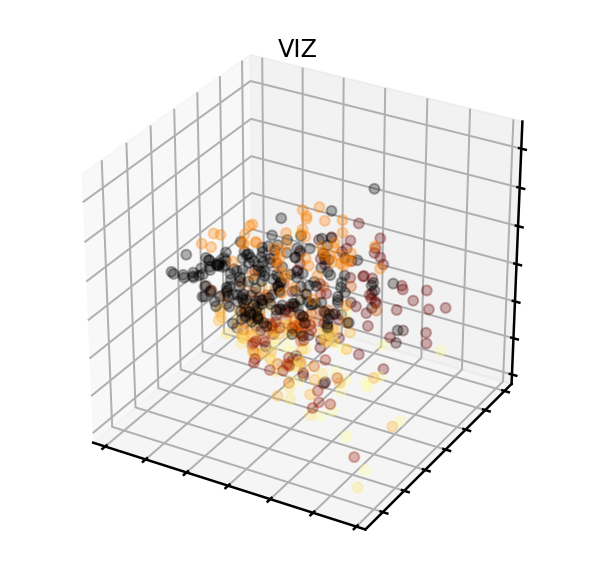

In [103]:
plot_sample = np.random.choice(len(X2), replace=False, size=500)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

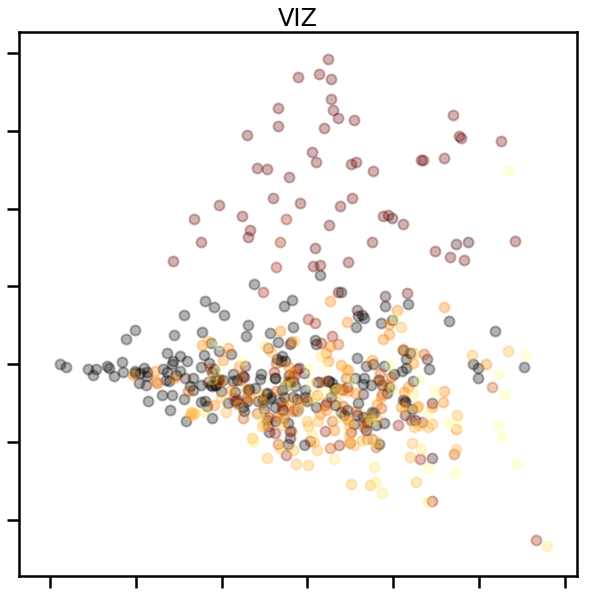

In [104]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

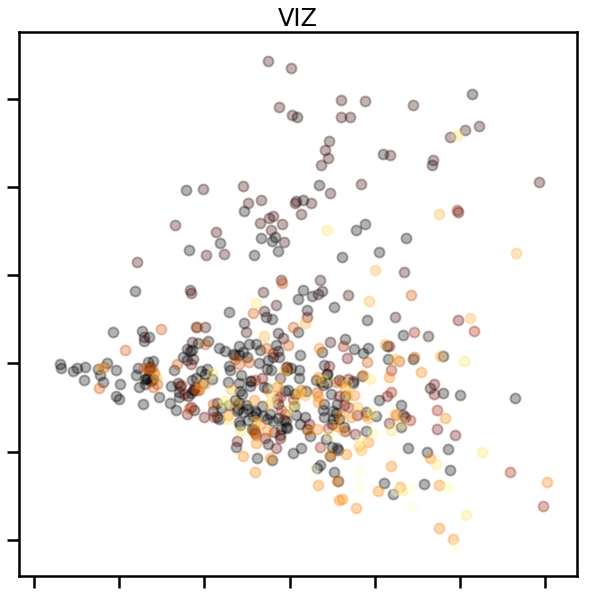

In [106]:
plot_vectors(X2[sample[:500]], labels=agg_sample[:500], dimensions=2)